<a href="https://colab.research.google.com/github/sahithya17b/Air-Quality/blob/main/Day_19_and_Milestone_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# === Load data ===
path = "/content/cleaned numeric.csv"
df = pd.read_csv(path)
df = df.select_dtypes(include=[np.number]).fillna(method='ffill').fillna(method='bfill')

targets = ['pm2.5', 'aqi']
features = [c for c in df.columns if c not in targets]
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# === Metrics Function ===
def evaluate(y_true, y_pred):
    # Remove NaNs and infs
    mask = (~np.isnan(y_true)) & (~np.isnan(y_pred)) & (~np.isinf(y_true)) & (~np.isinf(y_pred))
    y_true, y_pred = y_true[mask], y_pred[mask]
    # For MAPE, avoid division by zero
    nonzero_mask = y_true != 0
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100 if np.any(nonzero_mask) else np.nan
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, mape, r2

results = []

# ============================================================
# 1️⃣ ARIMA
# ============================================================
print("\n📘 Training ARIMA Models...")
for target in targets:
    series = df[target].fillna(method='ffill')
    model = ARIMA(series[:train_size], order=(2,1,2))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(series)-train_size)
    y_test = series[train_size:]
    mae, rmse, mape, r2 = evaluate(y_test.values, forecast.values)
    results.append(['ARIMA', target, mae, rmse, mape, r2])

# ============================================================
# 2️⃣ XGBOOST
# ============================================================
print("\n🟩 Training XGBoost Models...")
for target in targets:
    X_train, X_test = train[features], test[features]
    y_train, y_test = train[target], test[target]
    model_xgb = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=5)
    model_xgb.fit(X_train, y_train)
    y_pred = model_xgb.predict(X_test)
    mae, rmse, mape, r2 = evaluate(y_test.values, y_pred)
    results.append(['XGBoost', target, mae, rmse, mape, r2])

# ============================================================
# 3️⃣ LSTM (Optimized)
# ============================================================
print("\n🟦 Training LSTM Models...")
scaler = MinMaxScaler()
df_small = df.tail(5000).reset_index(drop=True)
df_scaled = pd.DataFrame(scaler.fit_transform(df_small), columns=df_small.columns)

def create_sequences(data, target_col, window=10):
    X, y = [], []
    for i in range(len(data)-window):
        X.append(data.iloc[i:i+window].values)
        y.append(data[target_col].iloc[i+window])
    return np.array(X), np.array(y)

window = 10
for target in targets:
    X, y = create_sequences(df_scaled, target, window)
    split = int(len(X)*0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    model_lstm = Sequential([
        LSTM(32, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
        Dense(1)
    ])
    model_lstm.compile(optimizer='adam', loss='mse')
    es = EarlyStopping(monitor='loss', patience=2, restore_best_weights=True)
    model_lstm.fit(X_train, y_train, epochs=5, batch_size=64, verbose=0, callbacks=[es])
    y_pred = model_lstm.predict(X_test, verbose=0).flatten()

    mae, rmse, mape, r2 = evaluate(y_test, y_pred)
    results.append(['LSTM', target, mae, rmse, mape, r2])

# ============================================================
# 📊 Final Comparison
# ============================================================
results_df = pd.DataFrame(results, columns=['Model', 'Target', 'MAE', 'RMSE', 'MAPE', 'R²'])
print("\n📈 Model Evaluation Results:")
print(results_df.to_string(index=False))

# ============================================================
# 🏆 Best Models Based on RMSE
# ============================================================
print("\n🏁 Best Models (Lowest RMSE per Target):")
best_models = results_df.loc[results_df.groupby('Target')['RMSE'].idxmin()].reset_index(drop=True)
print(best_models.to_string(index=False))

# ============================================================
# 📉 Visualization
# ============================================================
plt.figure(figsize=(8,4))
for target in targets:
    subset = results_df[results_df['Target']==target]
    plt.bar(subset['Model'], subset['RMSE'], alpha=0.7, label=target.upper())
plt.title("RMSE Comparison Across Models")
plt.ylabel("RMSE (Lower = Better)")
plt.legend()
plt.grid(True)
plt.show()



📘 Training ARIMA Models...

🟩 Training XGBoost Models...

🟦 Training LSTM Models...


ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.


📘 Training ARIMA Models...

🟩 Training XGBoost Models...

📈 Model Evaluation Results:
  Model Target       MAE      RMSE         MAPE        R²
  ARIMA  pm2.5  9.537594 11.792234 2.760317e+07 -0.079767
  ARIMA    aqi 23.149277 27.557729 5.893367e+01 -0.197067
XGBoost  pm2.5  2.430892  3.417022 3.523229e+06  0.909336
XGBoost    aqi  0.613287  1.318637 1.560508e+00  0.997259

🏁 Best Models (Lowest RMSE per Target):
  Model Target      MAE     RMSE         MAPE       R²
XGBoost    aqi 0.613287 1.318637 1.560508e+00 0.997259
XGBoost  pm2.5 2.430892 3.417022 3.523229e+06 0.909336


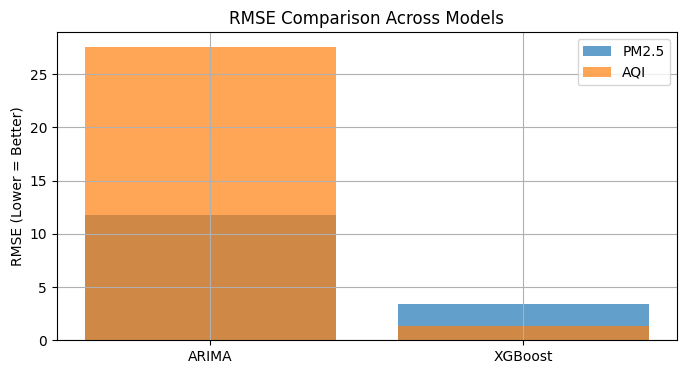

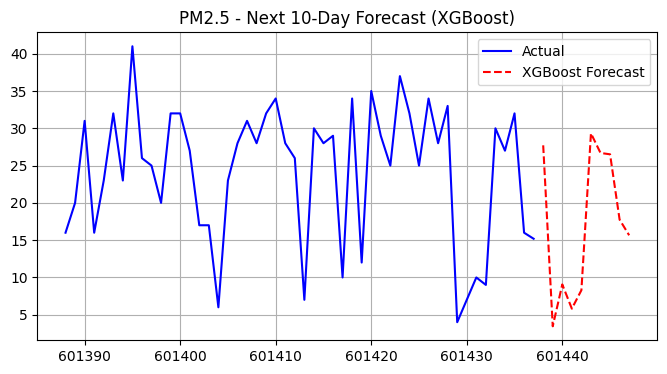

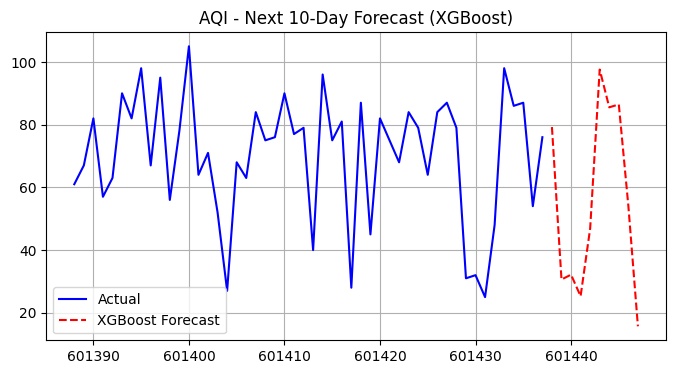


✅ Forecasts saved to: best_model_forecasts.csv


In [2]:
# ============================================================
# 🌍 AIR QUALITY FORECASTING COMPARISON (ARIMA vs XGBoost)
# Metrics: MAE | RMSE | MAPE | R²
# Forecast: Next 10 Days for PM2.5 and AQI
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor

# === Load data ===
path = "/content/cleaned numeric.csv"   # Change if needed
df = pd.read_csv(path)
df = df.select_dtypes(include=[np.number]).fillna(method='ffill').fillna(method='bfill')

targets = ['pm2.5', 'aqi']
features = [c for c in df.columns if c not in targets]
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# === Metrics Function ===
def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-6))) * 100
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, mape, r2

results = []
forecasts = {}

# ============================================================
# 1️⃣ ARIMA
# ============================================================
print("\n📘 Training ARIMA Models...")
for target in targets:
    series = df[target].fillna(method='ffill')
    model = ARIMA(series[:train_size], order=(2,1,2))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(series)-train_size)
    y_test = series[train_size:]
    mae, rmse, mape, r2 = evaluate(y_test, forecast)
    results.append(['ARIMA', target, mae, rmse, mape, r2])
    forecasts[f"ARIMA_{target}"] = model_fit.forecast(steps=10)

# ============================================================
# 2️⃣ XGBOOST
# ============================================================
print("\n🟩 Training XGBoost Models...")
for target in targets:
    X_train, X_test = train[features], test[features]
    y_train, y_test = train[target], test[target]
    model_xgb = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=5)
    model_xgb.fit(X_train, y_train)
    y_pred = model_xgb.predict(X_test)
    mae, rmse, mape, r2 = evaluate(y_test, y_pred)
    results.append(['XGBoost', target, mae, rmse, mape, r2])
    last_features = df[features].iloc[-10:].values
    forecasts[f"XGBoost_{target}"] = model_xgb.predict(last_features)

# ============================================================
# 📊 Final Comparison
# ============================================================
results_df = pd.DataFrame(results, columns=['Model', 'Target', 'MAE', 'RMSE', 'MAPE', 'R²'])
print("\n📈 Model Evaluation Results:")
print(results_df.to_string(index=False))

# ============================================================
# 🏁 Best Models (Lowest RMSE)
# ============================================================
print("\n🏁 Best Models (Lowest RMSE per Target):")
best_models = results_df.loc[results_df.groupby('Target')['RMSE'].idxmin()].reset_index(drop=True)
print(best_models.to_string(index=False))

# ============================================================
# 📉 Visualization of RMSE
# ============================================================
plt.figure(figsize=(8,4))
for target in targets:
    subset = results_df[results_df['Target']==target]
    plt.bar(subset['Model'], subset['RMSE'], alpha=0.7, label=target.upper())
plt.title("RMSE Comparison Across Models")
plt.ylabel("RMSE (Lower = Better)")
plt.legend()
plt.grid(True)
plt.show()

# ============================================================
# 🔮 Forecast Visualization + Save CSV
# ============================================================
forecast_output = []
for target in targets:
    best_model = best_models.loc[best_models['Target']==target, 'Model'].values[0]
    forecast = forecasts[f"{best_model}_{target}"]
    forecast_output.append(pd.DataFrame({
        'Target': target,
        'Model': best_model,
        'Day': np.arange(1, 11),
        'Forecast': forecast
    }))
    plt.figure(figsize=(8,4))
    plt.plot(df[target].iloc[-50:], label="Actual", color='blue')
    plt.plot(range(len(df), len(df)+10), forecast, label=f"{best_model} Forecast", color='red', linestyle='--')
    plt.title(f"{target.upper()} - Next 10-Day Forecast ({best_model})")
    plt.legend()
    plt.grid(True)
    plt.show()

# Save to CSV
forecast_df = pd.concat(forecast_output, ignore_index=True)
forecast_df.to_csv("best_model_forecasts.csv", index=False)
print("\n✅ Forecasts saved to: best_model_forecasts.csv")
